In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from warnings import filterwarnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
train_txt = glob('essays/*.txt')

In [3]:
train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(np.int64)

In [4]:
train['discourse_len'] = train['discourse_text'].apply(lambda x: len(x.split()))
train['pred_len'] = train['predictionstring'].apply(lambda x: len(x.split()))

In [5]:
train[train['pred_len'] != train['discourse_len']]

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,discourse_len,pred_len
107,C3811E7F1750,1622473475289,1641,1754,if we would just make stricker laws for phone ...,Concluding Statement,Concluding Statement 1,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,372F4B66B279,1622564912260,596,639,for navigation to wherever they are going,Claim,Claim 1,105 106 107 108 109 110 111 112,7,8
1525,4E1C636ABEAD,1622992466917,126,369,People should not be able to use cell phones w...,Position,Position 1,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,4E1C636ABEAD,1622992280991,370,478,"First, cell phones are a benefit and allows ev...",Claim,Claim 1,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,4E1C636ABEAD,1622992426147,479,907,"Kids, teenagers, adults, even grandparents hav...",Evidence,Evidence 1,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...,...,...,...,...
142607,5EF21F142C51,1617826841342,2870,3152,seeking people's opinions on making a choice i...,Concluding Statement,Concluding Statement 1,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,C0643251A96A,1617887956153,981,1413,i feel like for the bst advice ask more then o...,Evidence,Evidence 2,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,871287046F85,1617652582742,2469,2956,", asking for advice from multiple people will ...",Concluding Statement,Concluding Statement 1,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,B7BD520BE938,1618286838241,904,992,Seeking multiple opinions can help make a bett...,Claim,Claim 5,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


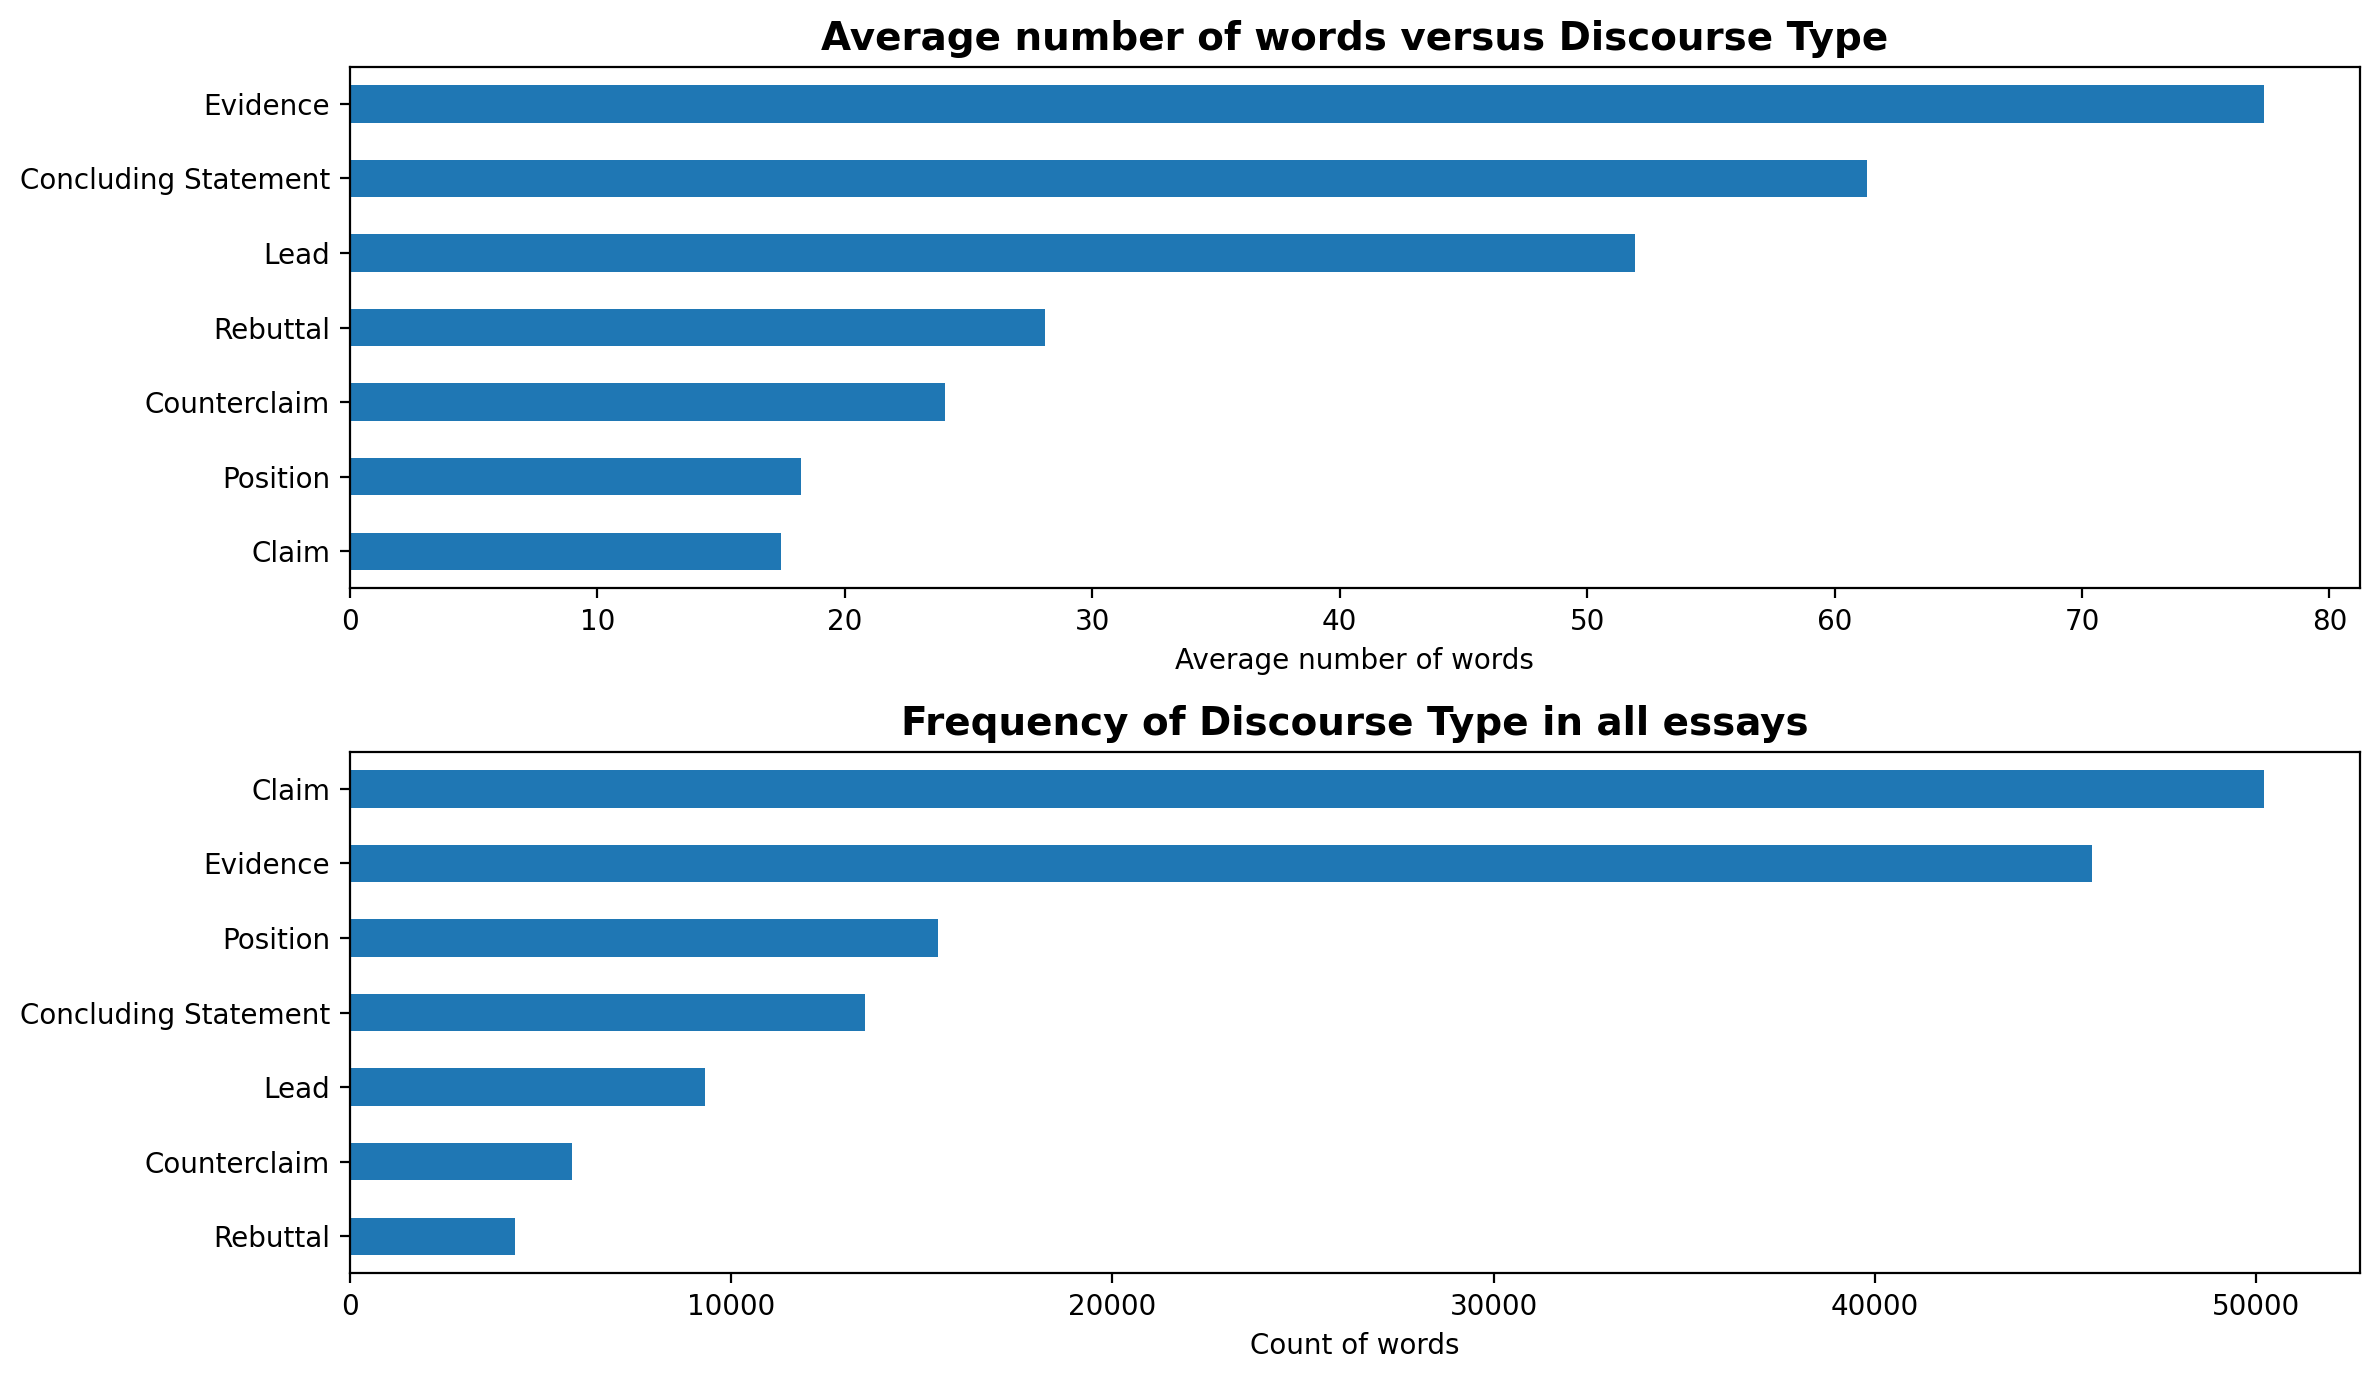

In [6]:
fig = plt.figure(figsize=(12, 7), dpi=200)
ax1 = fig.add_subplot(211)
ax1 = train.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind='barh')
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind='barh')
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Count of words", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout()
plt.show()

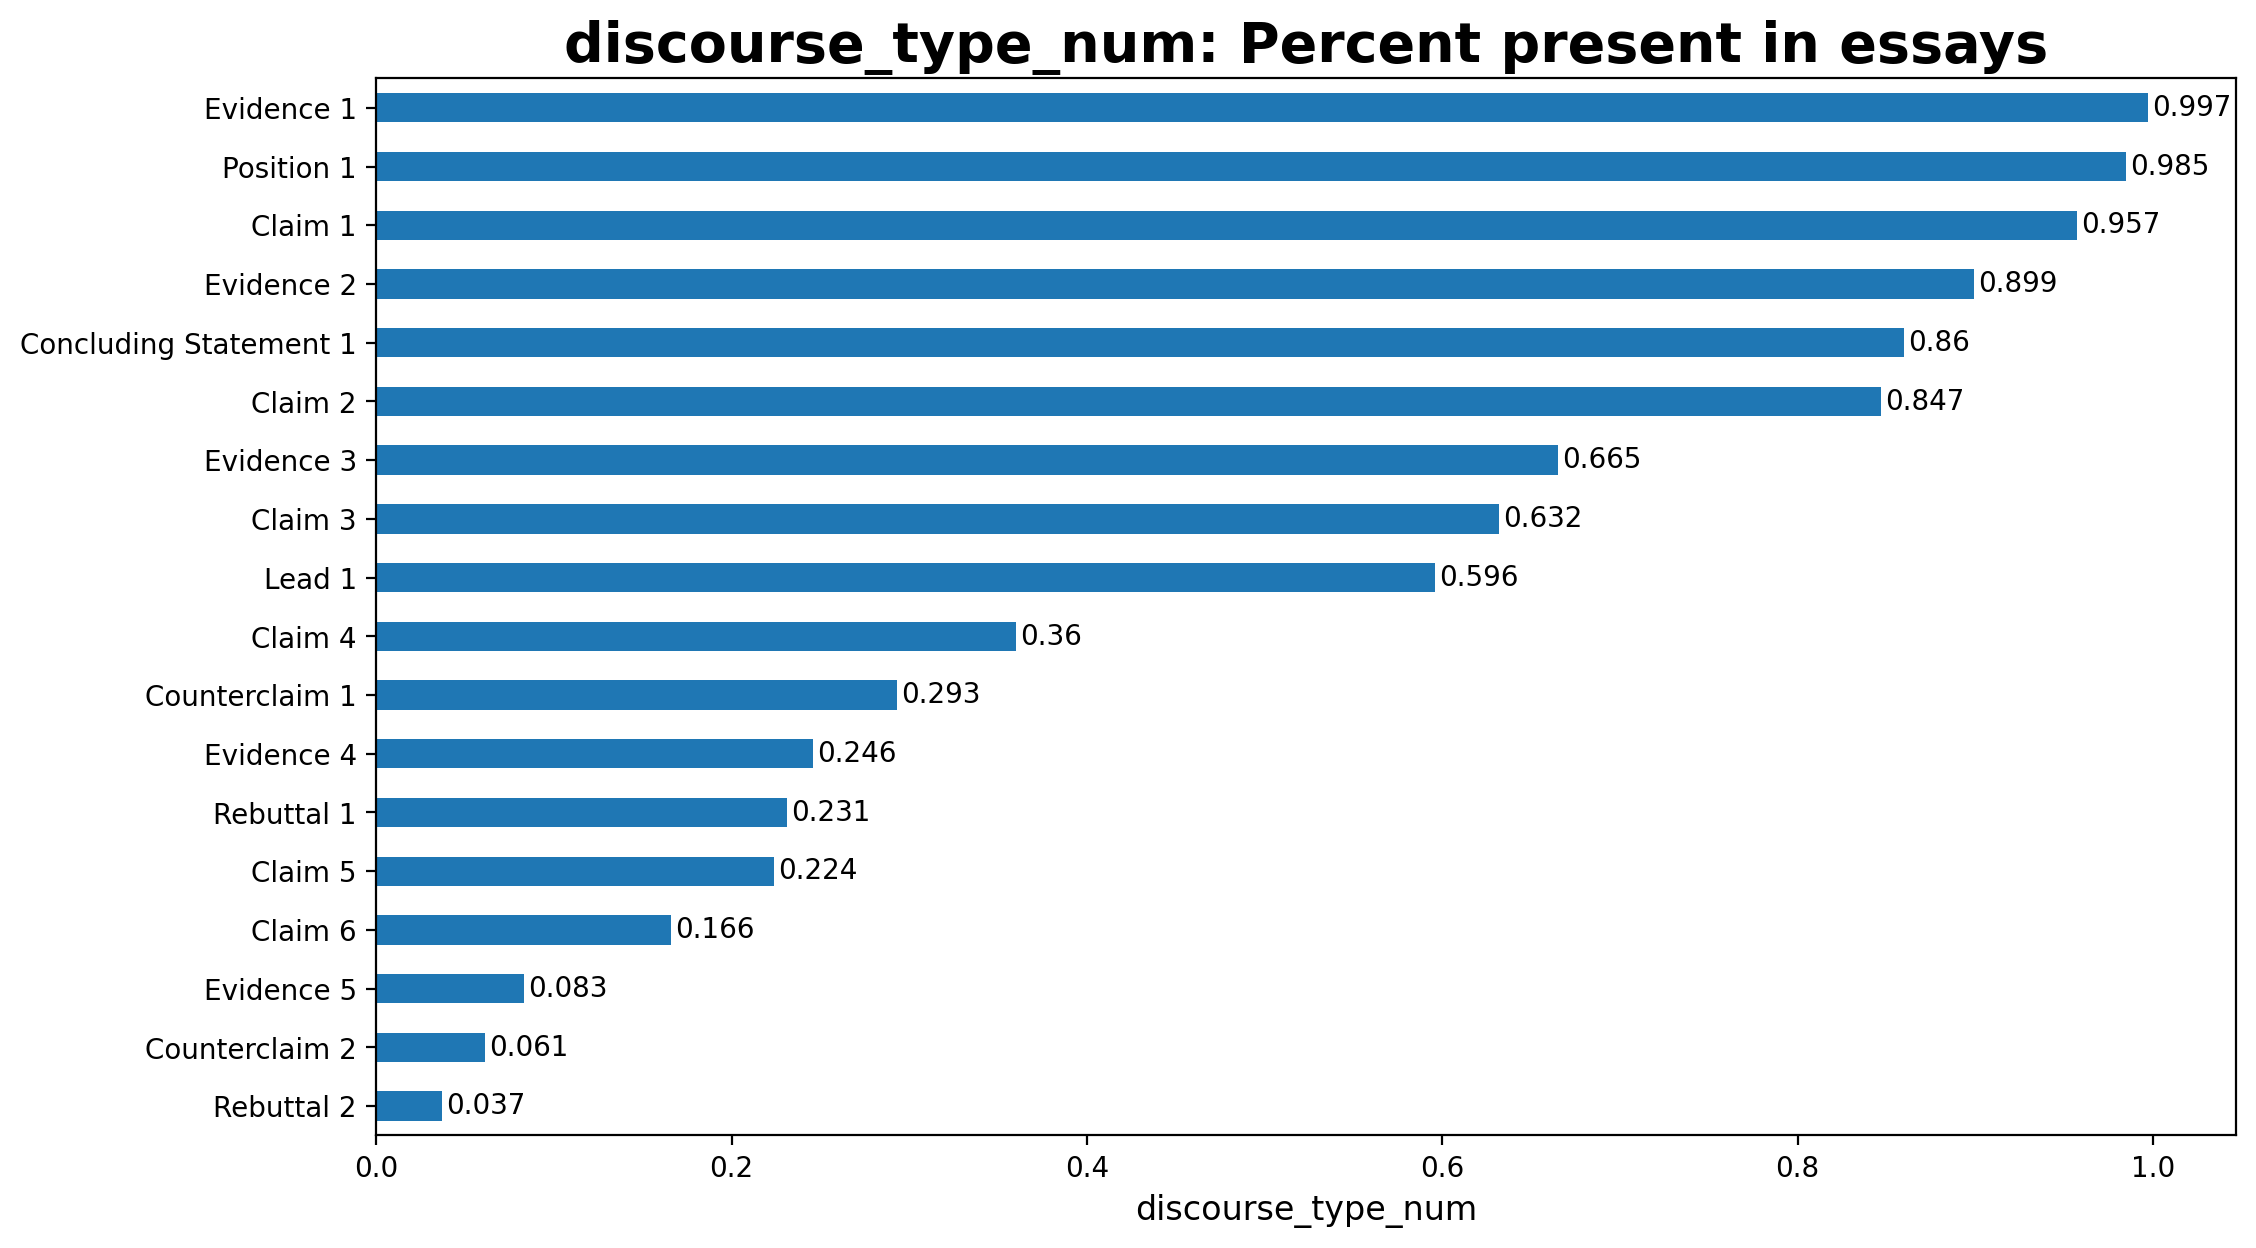

In [7]:
fig = plt.figure(figsize=(12, 7), dpi=200)
type_num_count = train['discourse_type_num'].value_counts(ascending=True).rename_axis('discourse_type_num').reset_index(name='count')
type_num_count['percentage'] = round(type_num_count['count'] / train['id'].nunique(), 3)
type_num_count.set_index('discourse_type_num', inplace=True)
ax = type_num_count[type_num_count['percentage'] > 0.03]['percentage'].plot(kind='barh')
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.set_xlabel('discourse_type_num', size=12)
ax.set_ylabel('')
ax.bar_label(ax.containers[0], label_type="edge", padding=1.5)
plt.show()

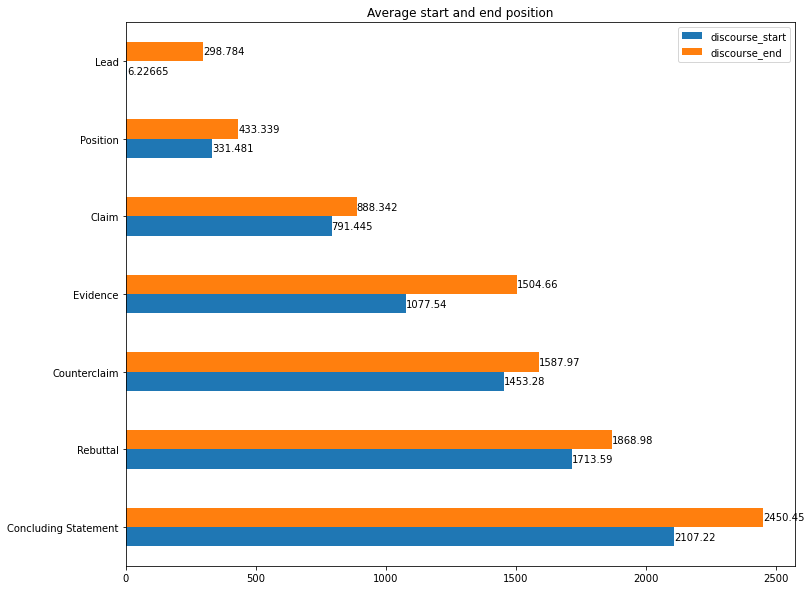

In [8]:
data = train.groupby('discourse_type')[['discourse_start', 'discourse_end']].mean().reset_index().sort_values(by='discourse_start', ascending=False)
ax = data.plot(kind='barh', x='discourse_type', title='Average start and end position', figsize=(12, 10))
ax.set_ylabel('')
ax.bar_label(ax.containers[1], label_type='edge', size=10)
ax.bar_label(ax.containers[0], label_type='edge', size=10)
plt.show()

In [9]:
train_first = train.drop_duplicates(subset='id', keep='first')['discourse_type'].value_counts().rename_axis('discourse_type').reset_index(name='count_first')
train_first['percent_first'] = round(train_first['count_first'] / train['id'].nunique(), 2)
train_last = train.drop_duplicates(subset='id', keep='last')['discourse_type'].value_counts().rename_axis('discourse_type').reset_index(name='count_last')
train_last['percent_last'] = round(train_last['count_last'] / train['id'].nunique(), 2)
train_first_last = train_first.merge(train_last, on='discourse_type')
train_first_last

,discourse_type,count_first,percent_first,count_last,percent_last
0,Lead,9298,0.60,3,0.00
1,Position,5760,0.37,521,0.03
2,Evidence,261,0.02,1609,0.10
3,Claim,255,0.02,285,0.02
4,Counterclaim,19,0.00,30,0.00
5,Concluding Statement,1,0.00,12993,0.83


In [10]:
char_dict = {}
word_dict = {}
for file in tqdm(train_txt):
    file_id = file.split('\\')[-1].split('.')[0]
    with open(file) as f:
        data = f.read()
    char_dict[file_id] = len(data.strip())
    word_dict[file_id] = len(data.split())
train['char_len'] = train['id'].map(char_dict)
train['word_len'] = train['id'].map(word_dict)

100%|███████████████████████████████████████████████████████████████████████████| 15594/15594 [02:24<00:00, 108.12it/s]


In [11]:
train['gap_length'] = np.nan
train.loc[0, 'gap_length'] = 7

for i in tqdm(range(1, len(train))):
    if (train.loc[i, 'id'] == train.loc[i - 1, 'id']) and (train.loc[i, 'discourse_start'] - train.loc[i - 1, 'discourse_end'] > 1):
        train.loc[i, 'gap_length'] = train.loc[i, 'discourse_start'] - train.loc[i - 1, 'discourse_end'] - 1
    elif (train.loc[i, 'id'] != train.loc[i - 1, 'id']) and (train.loc[i, 'discourse_start'] != 0):
        train.loc[i, 'gap_length'] = train.loc[i, 'discourse_start'] - 1
last_one = train.drop_duplicates(subset='id', keep='last')
last_one['gap_length_end'] = np.where(last_one['discourse_end'] < last_one['char_len'], 
                                      (last_one['char_len'] - last_one['discourse_end']), np.nan)
train = train.merge(last_one[['id', 'discourse_id', 'gap_length_end']], on=['id', 'discourse_id'], how='left')

100%|████████████████████████████████████████████████████████████████████████| 144292/144292 [00:43<00:00, 3352.43it/s]


In [12]:
total_gaps = train.groupby('id').agg({'char_len': 'first', 
                                      'gap_length': 'sum', 
                                      'gap_length_end': 'sum'})
total_gaps['total_gaps'] = total_gaps['gap_length'] + total_gaps['gap_length_end']
total_gaps['percent_gaps'] = round(total_gaps['total_gaps'] / total_gaps['char_len'], 2)
total_gaps.sort_values(by=['total_gaps'], ascending=False)

,char_len,gap_length,gap_length_end,total_gaps,percent_gaps
id,,,,,
9B23715DFB32,20368,43.0,18458.0,18501.0,0.91
ECFCAAECAD31,14787,65.0,13421.0,13486.0,0.91
E4559E81E304,12873,0.0,11107.0,11107.0,0.86
1C17A2B71357,8685,26.0,7779.0,7805.0,0.90
C278EDC82048,8015,16.0,7348.0,7364.0,0.92
...,...,...,...,...,...
8FA286B4FAE3,2123,0.0,0.0,0.0,0.00
8FA202BD4570,1681,0.0,0.0,0.0,0.00
8F90DA8188D9,1888,0.0,0.0,0.0,0.00


In [13]:
def add_missing_discourse(essay_id):
    cols_to_keep = ['discourse_start', 'discourse_end', 'discourse_type', 'gap_length', 'gap_length_end']
    df = train[train['id'] == essay_id][cols_to_keep].reset_index(drop=True)
    insert_row = len(df)
    
    for i in range(len(df)):
        if df.loc[i]['gap_length'] > 0:
            if i == 0:
                start = 0
            else:
                start = df.loc[i - 1]['discourse_end'] + 1
            end = df.loc[i]['discourse_start'] -1
            df.loc[insert_row] = [start, end, 'Nothing', np.nan, np.nan]
            insert_row += 1

    df = df.sort_values(by='discourse_start').reset_index(drop=True)
    
    if df.loc[len(df) - 1]['gap_length_end'] > 0:
        start = df.loc[len(df) - 1]['discourse_end'] + 1
        end = start + df.loc[len(df) - 1]['gap_length_end']
        df.loc[insert_row] = [start, end, 'Nothing', np.nan, np.nan]
    return df

In [14]:
def prined_color_esssay(essay_id):
    df = add_missing_discourse(essay_id)
    essay_path = 'essays/' +  essay_id + '.txt'
    ents = []
    for i, row in df.iterrows():
        ents.append({'start': int(row['discourse_start']), 
                     'end': int(row['discourse_end']), 
                     'label': row['discourse_type']})
    with open(essay_path) as f:
        data = f.read()
    docs = {'text': data, 'ents': ents}
    colors = {'Lead': '#EE11D0', 'Position': '#AB4DE1', 'Claim': '#1EDE71', 'Rebuttal': 'red',
              'Evidence': '#33FAFA', 'Counterclaim': '#4253C1', 'Concluding Statement': 'yellow'}
    options = {'ents': df['discourse_type'].unique().tolist(), 'colors': colors}
    spacy.displacy.render(docs, style='ent', options=options, manual=True, jupyter=True, minify=True)

In [19]:
prined_color_esssay('80667AD3FFD8')

7it [00:20,  2.94s/it]


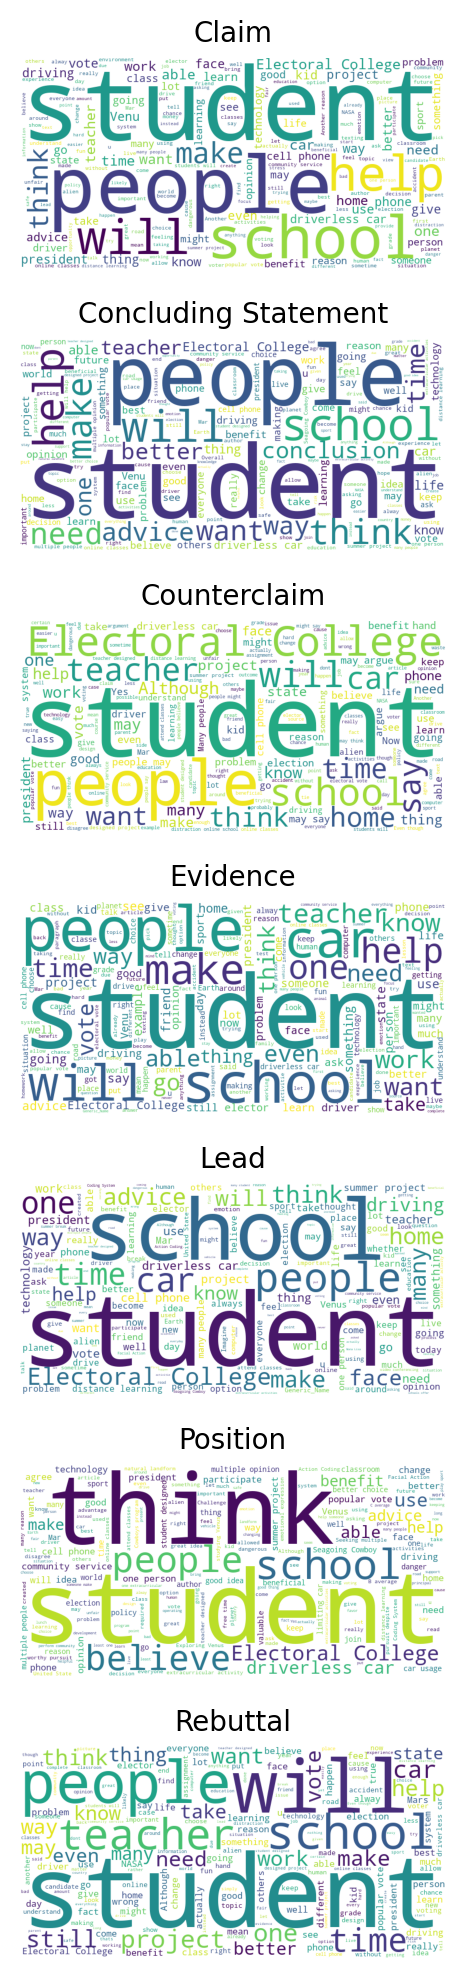

In [16]:
fig, axs = plt.subplots(7, 1, figsize=(12, 10), dpi=200)
for index, (discourse_type, df) in tqdm(enumerate(train.groupby('discourse_type'))):
    text = ' '.join(df['discourse_text'].values.tolist())
    wc = WordCloud(width=800, height=400, max_words=200, max_font_size=200,
                   stopwords=STOPWORDS, background_color='white').generate(text)
    axs[index].imshow(wc)
    axs[index].set_title(discourse_type, size=10)
    axs[index].axis('off')
plt.tight_layout()
plt.show()